# Deconvolution and decomposition of mouse cortex with Spotiphy
- by Ziqian Zheng <zzheng92@wisc.edu> and Jiyuna Yang <jiyuan.yang@stjude.org>.
- Last update: Nov 29th 2023

## Contents
1. [Install and load packages](#Install)
2. [Load Visium and scRNA data](#Load-data)
3. [Select marker genes for the deconvolution](#Marker)
4. [Deconvolution: Estimate cell abundance in spatial spots](#Deconvolution)
5. [Segmentation: Estimate cell number in each spatial spot](#Segmentation)
6. [Decomposition: Decompose the expression of each spatial spot into single-cell level](#Decomposition)
7. [Generate pseudo single-cell resolution image](#Pseudo_image)

## Install and load packages <a name="Install"></a>
If you're using you local environment, please ensure that `spotiphy` is correctly installed by following the instructions on its [GitHub page](https://github.com/jyyulab/Spotiphy).

If you're using Google Colab, please execute the following code block to install `spotiphy` and all its dependencies. To ensure the code runs smoothly in Google Colab, we will manually eliminate some unnecessary Jupyter variables.

**😮Important:** To get enough RAM, [Colab Pro](https://colab.research.google.com/signup) might be needed.

For the first time the following code block is executed in Google Colab, you may get an error of inconsistent package versions like this:

* ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

To solve this issue, simply ignore this error and **restart the session** (Click _Runtime_, then click _Restart Session_). Then you will be able to load the packages correctly.

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install -qq spotiphy

In [2]:
import spotiphy
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import scanpy as sc
import torch
import cv2

results_folder = 'results/mouse_brain/'
if not os.path.exists(results_folder):
  # Create result folder if it does not exist
  os.makedirs(results_folder)

## Load Visium data, scRNA data, and the HE staining image.<a name="Load-data"></a>

Verify the existence of the required data. If they are not present, download them from GitHub.

In [3]:
import requests
if not os.path.exists('data/'):
    os.makedirs('data/')

data_path = ['data/scRNA_mouse_brain.h5ad', 'data/ST_mouse_brain.h5ad',
             'data/img_mouse_brain.png']
urls = ['https://raw.githubusercontent.com/jyyulab/Spotiphy/main/tutorials/data/scRNA_mouse_brain.h5ad',
        'https://raw.githubusercontent.com/jyyulab/Spotiphy/main/tutorials/data/ST_mouse_brain.h5ad',
        'https://raw.githubusercontent.com/jyyulab/Spotiphy/main/tutorials/data/img_mouse_brain.png']

for i, path in enumerate(data_path):
    if not os.path.exists(path):
        response = requests.get(urls[i], allow_redirects=True)
        with open(path, 'wb') as file:
            file.write(response.content)
        del response

Load the scRNA data, visium data and the corresponding H&E staining image.

In [4]:
adata_sc = sc.read_h5ad("data/scRNA_mouse_brain.h5ad")
adata_st = sc.read_h5ad("data/ST_mouse_brain.h5ad")
img = cv2.imread("data/img_mouse_brain.png")

key_type = 'celltype'
type_list = sorted(list(adata_sc.obs[key_type].unique()))
print(f'There are {len(type_list)} cell types: {type_list}')

There are 14 cell types: ['Astro', 'CA', 'DG', 'L2/3 IT CTX', 'L4 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 IT CTX', 'L6 CT CTX', 'L6b CTX', 'Microglia', 'Oligo', 'SUB']


scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


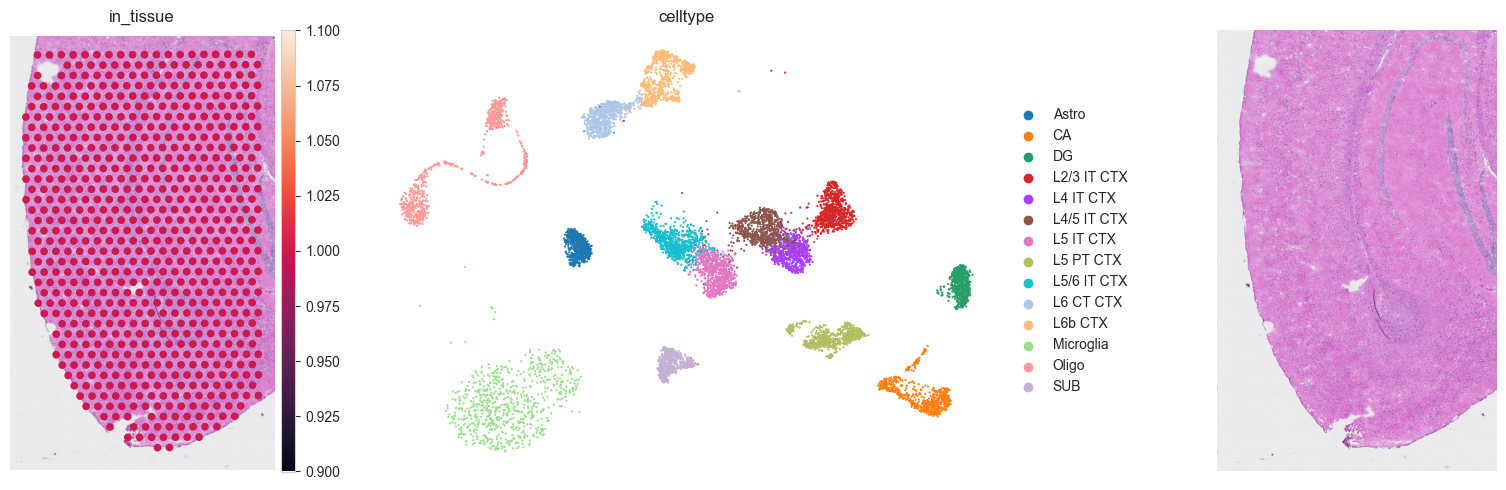

In [5]:
fig, axs = mpl.pyplot.subplots(1, 3, figsize=(20, 5))
sc.pl.spatial(adata_st, color="in_tissue", frameon=False, show=False, ax=axs[0])
sc.pl.umap(adata_sc, color="celltype", size=10, frameon=False, show=False, ax=axs[1])
axs[2].imshow(img[:, :, [2, 1, 0]])  # In default, cv2 uses BGR. So we convert BGR to RGB.
axs[2].axis('off')
mpl.pyplot.tight_layout()

In [7]:
adata_st.uns['']

{'spatial': {'NCF221-D': {'images': {'hires': array([[[0.92156863, 0.92156863, 0.92941177, 1.        ],
            [0.92156863, 0.92156863, 0.92941177, 1.        ],
            [0.92156863, 0.92156863, 0.92941177, 1.        ],
            ...,
            [0.87058824, 0.6666667 , 0.85490197, 1.        ],
            [0.8862745 , 0.68235296, 0.87058824, 1.        ],
            [0.85882354, 0.6313726 , 0.8392157 , 1.        ]],
    
           [[0.92156863, 0.92156863, 0.92941177, 1.        ],
            [0.92156863, 0.92156863, 0.92941177, 1.        ],
            [0.92156863, 0.92156863, 0.92941177, 1.        ],
            ...,
            [0.8784314 , 0.6509804 , 0.85490197, 1.        ],
            [0.85882354, 0.60784316, 0.84313726, 1.        ],
            [0.85882354, 0.6039216 , 0.83137256, 1.        ]],
    
           [[0.92156863, 0.92156863, 0.92941177, 1.        ],
            [0.92156863, 0.92156863, 0.92941177, 1.        ],
            [0.92156863, 0.92156863, 0.92941

## Select marker genes for the deconvolution <a name="Marker"></a>
Initialize the spatial trancriptomics and scRNA data. Specifically,
- `adata_sc` and `adata_st` are normalized
- cells and genes in `adata_sc` are filtered
- only the common genes shared by `adata_sc` and `adata_st` are kept

In [ ]:
adata_sc, adata_st = spotiphy.initialization(adata_sc, adata_st, verbose=1)

Select marker genes based on pairwise statistical tests. The selected marker genes are saved as a CSV file.

Users can adjust the following arguments:

- `n_select`: the maximum number of marker genes select for each cell type
- `threshold_p`: threshold of the $p$-value to be considered significant
- `threshold_fold`: threshold of the fold-change to be considered significant
- `q`: Since more than one $p$-values are obtained in using the pairwise tests, we only consider the $p$-value at quantile `q`. For additional details, please refer to the supplementary material of the paper.
- `return_dict`: Whether return a dictionary representing the marker genes selected for each cell type, or just return the list of all selected marker genes.

The parameters specified in the following code block provide a good starting point.

In [ ]:
marker_gene_dict = spotiphy.sc_reference.marker_selection(adata_sc, key_type=key_type, return_dict=True, 
                                                          n_select=50, threshold_p=0.1, threshold_fold=1.5, 
                                                          q=0.15)
marker_gene = []
marker_gene_label = []
for type_ in type_list:
    marker_gene.extend(marker_gene_dict[type_])
    marker_gene_label.extend([type_]*len(marker_gene_dict[type_]))
marker_gene_df = pd.DataFrame({'gene':marker_gene, 'label':marker_gene_label})
marker_gene_df.to_csv(results_folder+'marker_gene.csv')
adata_sc = adata_sc[:, marker_gene]
adata_st = adata_st[:, marker_gene]

If saving of the selected marker genes to file is not necessary, the code can be simplified to
```python
marker_gene_dict = spotiphy.sc_reference.marker_selection(adata_sc, key_type=key_type, n_select=50, threshold_p=0.1, 
                                                          threshold_fold=1.5, q=0.15)
adata_sc = adata_sc[:, marker_gene]
adata_st = adata_st[:, marker_gene]
```

Construct the single_cell reference matrix based on the selected marker genes and visualize the results. We can examine which cell types are similar according to the heatmap.

In [ ]:
sc_ref = spotiphy.construct_sc_ref(adata_sc, key_type=key_type)
spotiphy.sc_reference.plot_heatmap(adata_sc, key_type, save=True, out_dir=results_folder)

## Deconvolution: Estimate cell abundance in spatial spots <a name="Deconvolution"></a>
For performing the deconvolution, we calculate the posterior distribution of certain parameters within a probabilistic generative model using [`Pyro`](https://pyro.ai/).

Parameters of the function `estimation_proportion`:
- `X`: Spatial transcriptomics data. n_spot*n_gene.
- `adata_sc`: scRNA data (Anndata).
- `sc_ref`: Single cell reference. n_type*n_gene.
- `type_list`: List of the cell types.
- `key_type`: Column name of the cell types in adata_sc.
- `batch_prior`: Parameter involved in the prior distribution of the batch effect factors. It is recommended to select from $[1, 2]$.
- `n_epoch`: Number of training epoch.

In [ ]:
type(sc_ref[0, 0])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X = np.array(adata_st.X)
cell_proportion = spotiphy.deconvolution.estimation_proportion(X, adata_sc, sc_ref, type_list, key_type, n_epoch=8000, 
                                                               plot=True, batch_prior=1, device=device)
adata_st.obs[type_list] = cell_proportion
np.save(results_folder+'proportion.npy', cell_proportion)  # Save the proportion for future usage

In [ ]:
vmax = np.quantile(adata_st.obs[type_list].values, 0.98, axis=0)
vmax[vmax<0.05] = 0.05
with mpl.rc_context({'figure.figsize': [3, 5], 'figure.dpi': 400, 'xtick.labelsize': 0}):
    ax = sc.pl.spatial(adata_st, cmap='viridis', color=type_list, img_key='hires', vmin=0, vmax=list(vmax), 
                       size=1.3, show=False, ncols=5, alpha_img=0.4)
    ax[0].get_figure().savefig(results_folder+'Spotiphy.jpg')

## Segmentation: Estimate cell number in each spatial spot <a name="Segmentation"></a>
We use the package `Stardist` to segmente nuclei from H&E staining image. Then the number of nuclei in each spot is counted. Note that to get the results above, the image is not required.

Parameters use in function `Segmentation`:

- `img` (numpy.ndarray):. Three channel stained image. In default, it should be hematoxylin and eosin (H&E) stained image.
- `spot_center`: Coordinates of the center of the spots.
- `out_dir`: Output directory.
- `Prob_thresh`, `nms_thresh`: Two thresholds used in Stardist. User should adjust these two thresholds based on the segmentation results. More details can be found [here](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_stardist.html).
- `spot_radius`: Radius of the spots. In 10X Visium, it should be 36.5.
- `n_tiles`: Out of memory (OOM) errors can occur if the input image is too large. To avoid this problem, the input image is broken up into (overlapping) tiles that are processed independently and re-assembled. In default, we break the image into 8*8 tiles.

In [ ]:
if not os.path.exists(results_folder+'segmentation/'):
    os.makedirs(results_folder+'segmentation/')
Segmentation = spotiphy.segmentation.Segmentation(img[:, :, [2, 1, 0]], adata_st.obsm['spatial'], 
                                                  n_tiles=(2, 2, 1),
                                                  out_dir=results_folder+'segmentation/')
Segmentation.segment_nucleus(save=True)
n_cell_df = Segmentation.n_cell_df

Plot a small section of the segmented results for examination.

In [ ]:
Segmentation.plot(save=True, crop=(2000, 2500, 1000, 1500),
                  path=results_folder+'segmentation/segmentation_sample.jpg')

## Decomposition: Decompose the expression of each spatial spot into single-cell level <a name="Decomposition"></a>


Decompose the spatial transcriptomics. Note that since we want to decompose all genes in the spatial transcriptomics, we reload the scRNA-seq data and spatial transcriptomics data. The argument `n_cell` represents the number of cells in each spot. When the histology image is not available, user can either estimate the cell number or simply set `n_cell` to `None`. When `n_cell` is `None`, we will assume that a cell type does not exist in a spot unless its proportion is larger than `threshold`. For more details, please refer to the [document](https://jyyulab.github.io/Spotiphy/deconvolution.html#deconvolution.decomposition).

In [ ]:
adata_sc_orig = sc.read_h5ad("data/scRNA_mouse_brain.h5ad")
adata_st_orig = sc.read_h5ad("data/ST_mouse_brain.h5ad")
adata_st_decomposed = spotiphy.deconvolution.decomposition(adata_st_orig, adata_sc_orig, key_type, 
                                                           cell_proportion, save=True,out_dir=results_folder, 
                                                           verbose=1, spot_location=adata_st_orig.obsm['spatial'],
                                                           filtering_gene=True, 
                                                           n_cell=n_cell_df['cell_count'].values,
                                                           filename='ST_decomposition.h5ad')

## Generate pseudo single-cell resolution image <a name="Pseudo_image"></a>
As only the nuclei are stained in the H&E staining image, we first infer the boundary of each cell.

Specifically, we gradually expend the area of each cell from the center of its nucleus. The expansion is stopped when: 1. the area of the cell is already larger than `max_area`, 2. the neighborhood are all occupied by other cells, or 3. the largest distance from the cell boundary to the nucleus center is larger than `max_dist`. `delta` represent the increase of expansion distance in each iteration.

In [ ]:
search_direction = [[1, 0], [0, 1], [-1, 0], [0, -1], [2, 0], [0, 2], [-2, 0], [0, -2], 
                    [1, 1], [-1, 1], [-1, -1], [1, -1]]
boundary_dict = spotiphy.segmentation.cell_boundary(Segmentation.nucleus_df[['x', 'y']].values, 
                                                    img_size=img.shape[:2], max_dist=25, max_area=580, 
                                                    verbose=0, search_direction=search_direction, delta=2)

We can save the dictionary of the cell boundaries for future usage.

In [ ]:
with open(results_folder+f'segmentation/boundary_dict.pkl', 'wb') as file:
    pickle.dump(boundary_dict, file)

Assign cell types to nuclei in the spatial tissue using these three steps:

- Function `proportion_to_count`: compute the count of each cell type using the segmentation outcomes and the estimated proportions.
- Function `assign_type_spot`: assign cell types to nuclei within the spots.
- Function `cell_proportion_smooth`: allocate cell types to nuclei located outside the spots.

In [ ]:
cell_number = spotiphy.deconvolution.proportion_to_count(cell_proportion, n_cell_df['cell_count'].values, 
                                                         multiple_spots=True)
Segmentation.nucleus_df = (
    spotiphy.deconvolution.assign_type_spot(Segmentation.nucleus_df, Segmentation.n_cell_df, 
                                            cell_number, type_list))
Segmentation.nucleus_df, cell_proportion_smooth = (
    spotiphy.deconvolution.assign_type_out(Segmentation.nucleus_df, cell_proportion, 
                                           Segmentation.spot_center, type_list, band_width=150))

Define the class `plot_visium` for generating the pseudo image. Then we plot the legend of the images.

In [ ]:
plot_visium = spotiphy.plot.Plot_Visium(segmentation=Segmentation, boundary_dict=boundary_dict, 
                                        type_list=type_list)
plot_visium.plot_legend(save=results_folder+'legend.png')

We now generate the pseudo image. The user need to specify the following arguments:
- `shape`: When adding the cells, which shape should be used. Should be selected from `cell`, `nucleus`, or `circle`
- `cell`: Which group of cells should be included in the image: `in`, `out`, or `both`. 
- `boundary`: Which group of boundaries should be included in the image: `in`, `out`, `both` or `None`. 

For example, if we want to generate a pseudo image with cells inside the spots, the following code can be used.

In [ ]:
plot_visium.plot(background=False, save=results_folder+'pseudo_image_in.png', spot_color=(200, 200, 200), 
                 shape='cell', cell='in', boundary='in', dpi=200)

If we want to show all the cells using circles without the cell boundary, we can use the following code:

In [ ]:
plot_visium.plot(background=False, save=results_folder+'pseudo_image_both_circle.png',
                 spot_color=(200, 200, 200), shape='circle', cell='both', boundary=None,
                 dpi=200)

Note that we can also save the updated class `Segmentation` for future usage.

In [ ]:
with open(results_folder+f'segmentation/Segmentation.pkl', 'wb') as file:
    pickle.dump(Segmentation, file)